In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

sns.set()

# Métodos de Clustering
## K-means

K-Means es uno de los algoritmos de aprendizaje automático no supervisado más utilizados para el agrupamiento o clustering de datos. Su objetivo es dividir un conjunto de datos en grupos o clústeres de manera que los elementos dentro de un mismo clúster sean similares entre sí y, al mismo tiempo, diferentes de los elementos en otros clústeres. Este algoritmo es útil para descubrir patrones y estructuras en los datos sin necesidad de etiquetas o categorías predefinidas.

Para este tipo de algoritmo vamos a usar el siguiente dataset [mall_customers.csv](https://www.kaggle.com/datasets/shwetabh123/mall-customers). Este dataset posee datos de clientes que asisten a un Mall, edad, ingresos anuales y un score dado el nivel de gastos en el Mall. Se busca establecer diferente tipo de clientes que nos permitan establecer campañas de marketing de préstamos más personalizadas.

In [2]:
# Cargamos los datos con pandas
df = pd.read_csv("mall_customers.csv")
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
df.columns

Index(['CustomerID', 'Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

Para este problema, no vamos a usar la edad para establecer tipos de clientes. Nos vamos a quedar con **Annual Income (k$)** y **Spending Score (1-100)**

In [5]:
X = df.iloc[:, [3,4]].values
X = X.astype('float64') 

Un problema que tenemos es que K-means necesita de entrada el número de clusters que queremos calcular. Pero en este problema no tenemos idea de cuántos tipos de clientes tenemos. Por lo que necesitamos establecer de alguna forma este número. Una forma de hacerlo usando la *Suma de Cuadrados Intracluster* (WCSS) y ver cual es el número que cluster que minimiza este valor.

Este procedimiento es algo parecido a la validación cruzada en aprendizaje supervisado.

Vamos a usar de sklearn el modelo [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [6]:
from sklearn.cluster import KMeans

In [7]:
# Vamos a calcular diferentes modelos de K-means, cambiando la cantidad de cluster en cada iteración
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i,       
                    init = "k-means++",     # Esta forma busca una inicialización que converga más rapido que incializar al azar 
                    max_iter = 300,         # El numero maximo de iteraciones
                    n_init = 10,            # Cuanta veces repite la ejecucion del algoritmo hasta que se quede con el mejor caso
                    random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)            # SKlearn le llama inercia a WCSS

Ahora grafiquemos los resultados

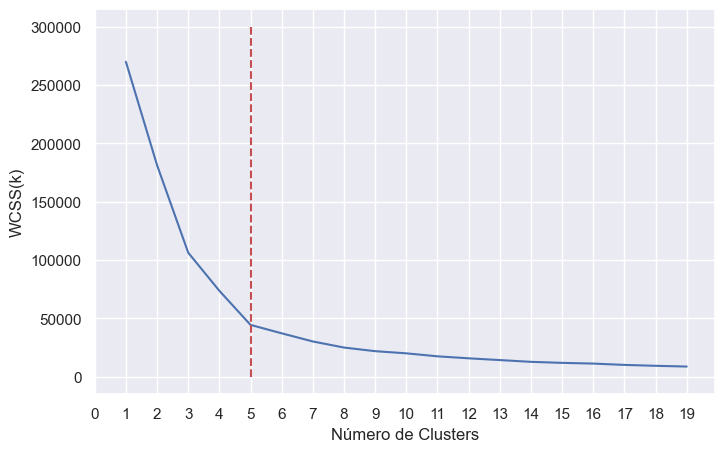

In [8]:
plt.figure(figsize=(8, 5)) 
plt.plot(range(1,20), wcss)
plt.plot([5, 5], [0, 300000], color="r", linestyle="--")
plt.xlabel("Número de Clusters", fontsize=12)
plt.ylabel("WCSS(k)", fontsize=12)
plt.xticks(np.arange(0, 20, step=1))
plt.show()

Lo que tenemos que ver acá, medio a ojo, es cual el minimo numero de clusters en donde WCSS(k) empieza a estabilizarse. Este método se llama el **método del codo**. En este caso vamos a elegir K=5

In [9]:
# Aplicar el método de k-means para segmentar el data set
kmeans = KMeans(n_clusters = 5, init="k-means++", max_iter = 300, n_init = 10, random_state = 0)

In [10]:
y_kmeans = kmeans.fit_predict(X)

Ahora visualizamos a los clusters

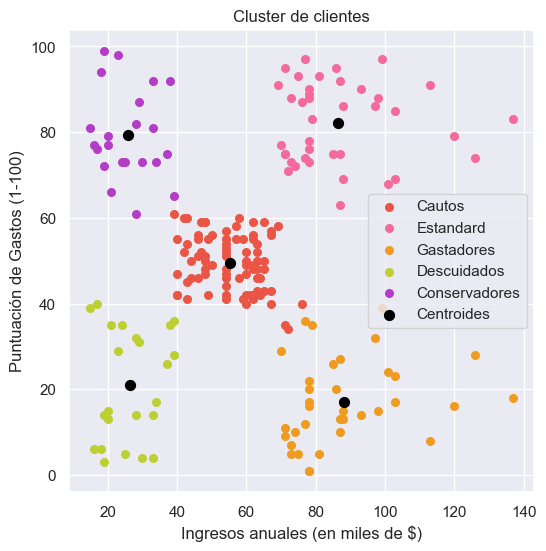

In [11]:
# Visualización de los clusters
plt.figure(figsize=(6, 6)) 
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 30, c = "#ea5545", label = "Cautos")
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 30, c = "#f46a9b", label = "Estandard")
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 30, c = "#ef9b20", label = "Gastadores")
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 30, c = "#bdcf32", label = "Descuidados")
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 30, c = "#b33dc6", label = "Conservadores")
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s = 50, c = "black", label = "Centroides")
plt.title("Cluster de clientes", fontsize=12)
plt.xlabel("Ingresos anuales (en miles de $)", fontsize=12)
plt.ylabel("Puntuación de Gastos (1-100)", fontsize=12)
plt.legend()
plt.show()

Si ahora quisieramos usar a esta clusterización como información para nuestro dataframe, se puede hacer:

In [12]:
df['Cluster'] = y_kmeans
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,3
1,2,Male,21,15,81,4
2,3,Female,20,16,6,3
3,4,Female,23,16,77,4
4,5,Female,31,17,40,3


O inclusive guardar el nombre de categorias que elegimos

In [13]:
categories = {
    0: "cautious",
    1: "standard",
    2: "spenders",
    3: "careless",
    4: "conservatives"
}

df["Client category"] = df["Cluster"].replace(categories)

In [14]:
df.head(10)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster,Client category
0,1,Male,19,15,39,3,careless
1,2,Male,21,15,81,4,conservatives
2,3,Female,20,16,6,3,careless
3,4,Female,23,16,77,4,conservatives
4,5,Female,31,17,40,3,careless
5,6,Female,22,17,76,4,conservatives
6,7,Female,35,18,6,3,careless
7,8,Female,23,18,94,4,conservatives
8,9,Male,64,19,3,3,careless
9,10,Female,30,19,72,4,conservatives


## Hierarchical Clustering

Otro algoritmo no tan popular es el **Hierarchical Clustering** o **Agrupamiento jerárquico**. Este tipo de agrupamiento se realiza mediante una organización en estructura de árbol o dendrograma. Tenemos del tipo Aglomerativas que son las que vimos en teoría, que cada observación tiene su propio grupo y se van fusionando o del tipo Divisiva que las observaciones comienzan en un solo cluster y se va dividiendo a medida que se baja de jerarquía.

La forma en decidir separar los grupos es usando una métrica de disimilitud tal como la distancia euclidiana.

Vamos a usar de sklearn el modelo [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

In [15]:
from sklearn.cluster import AgglomerativeClustering

Este método es mas sensible a la escala de los atributos, por lo que vamos a hacer un escalamiento

In [16]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [17]:
model = AgglomerativeClustering(n_clusters=None,             # Podemos definir el numero de cluster a definir
                                metric="euclidean",          # Esta es la metrica de disimilitud
                                compute_full_tree=True,      # Para este ejercicio vamos a construir todo el arbol
                                linkage='ward',              # Tipo de calculo de disimilitud, aqui usamos a Centroide
                                distance_threshold=0,     
                                compute_distances=True)      # Esto lo hacemos para poder graficar del dendrograma, sino no deberia usarse

In [18]:
model = model.fit(scaled_X)

In [19]:
# Creamos esta funcion que nos permite graficar el dendrograma usando Scipy. 
# Obtenido de https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):

    # Crea la cuenta de cuantas muestras hay en cada nodo (hoja y ramas)
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Armamos la matriz de union. Algo que AgglomerativeClustering no nos entrega
    # La matriz de union esta formada por la estructura de los nodos (model.children_), las distancias (model.distances_)
    # y la cuenta de muestra de cada nodo.
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Graficamos el dendrograma
    dendrogram(linkage_matrix, **kwargs)

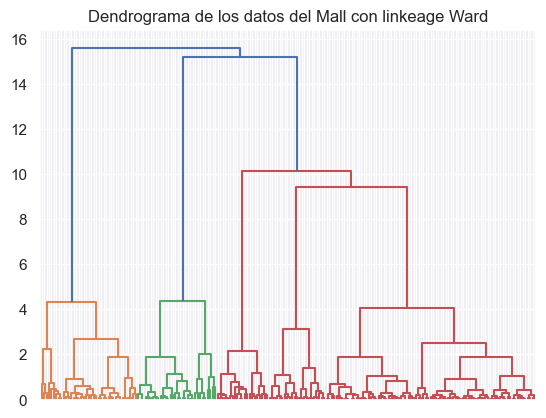

In [20]:
plt.title("Dendrograma de los datos del Mall con linkeage Ward")
plot_dendrogram(model, truncate_mode="level", p=60)
plt.xticks(visible=False);

Veamos los otros tipos de linkeage

In [21]:
model_complete = AgglomerativeClustering(n_clusters=None, metric="euclidean", compute_full_tree=True, 
                                         linkage='complete', distance_threshold=0, compute_distances=True)
model_average = AgglomerativeClustering(n_clusters=None, metric="euclidean", compute_full_tree=True, 
                                        linkage='average', distance_threshold=0, compute_distances=True)
model_single = AgglomerativeClustering(n_clusters=None, metric="euclidean", compute_full_tree=True, 
                                       linkage='single', distance_threshold=0, compute_distances=True)

model_complete = model_complete.fit(scaled_X)
model_average = model_average.fit(scaled_X)
model_single = model_single.fit(scaled_X)

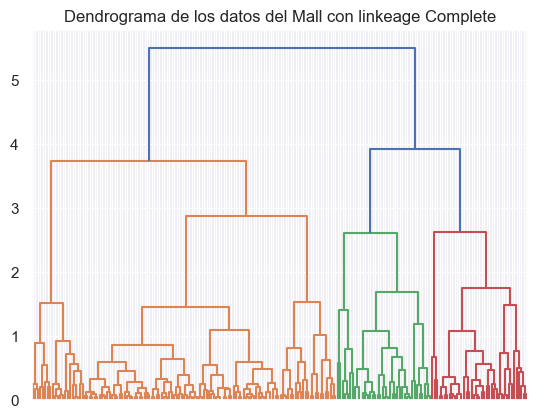

In [22]:
plt.title("Dendrograma de los datos del Mall con linkeage Complete")
plot_dendrogram(model_complete, truncate_mode="level", p=60)
plt.xticks(visible=False);

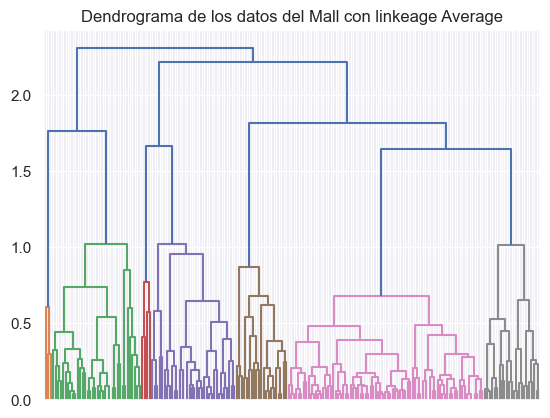

In [23]:
plt.title("Dendrograma de los datos del Mall con linkeage Average")
plot_dendrogram(model_average, truncate_mode="level", p=60)
plt.xticks(visible=False);

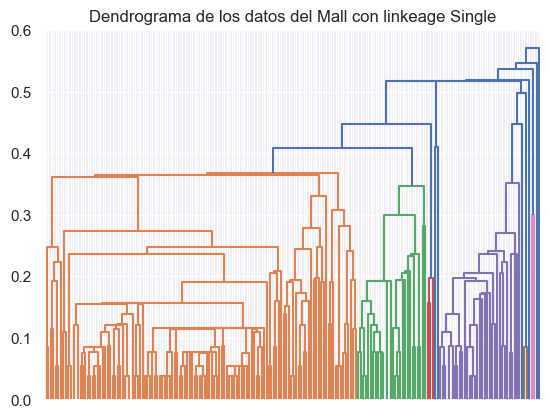

In [24]:
plt.title("Dendrograma de los datos del Mall con linkeage Single")
plot_dendrogram(model_single, truncate_mode="level", p=60)
plt.xticks(visible=False);

Veamos el numero optimo de clusters 

Elijamos 5 clusters igual que en el caso de K-Means, pero similar al caso de K-Means podria aplicar el método del codo o tambien el [método de la silueta](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

In [25]:
model_complete = AgglomerativeClustering(n_clusters=5, metric="euclidean", linkage='complete')
model_single = AgglomerativeClustering(n_clusters=5, metric="euclidean", linkage='single')
model_ward = AgglomerativeClustering(n_clusters=5, metric="euclidean", linkage='ward')
model_average = AgglomerativeClustering(n_clusters=5, metric="euclidean", linkage='average')

y_complete = model_complete.fit_predict(scaled_X)
y_single = model_single.fit_predict(scaled_X)
y_ward = model_ward.fit_predict(scaled_X)
y_average = model_average.fit_predict(scaled_X)

Visualizamos los clusters

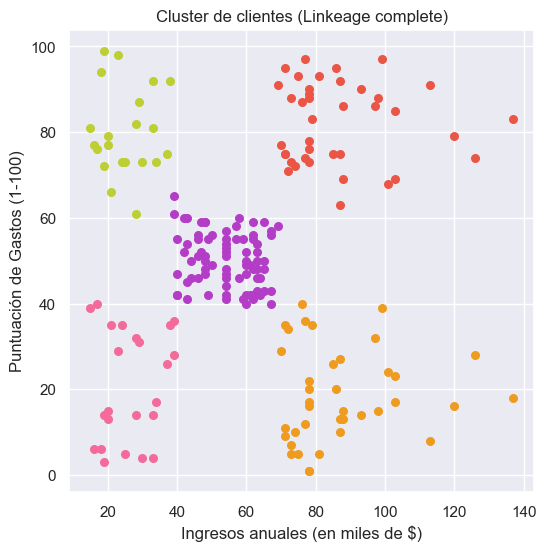

In [26]:
# Visualización de los clusters
plt.figure(figsize=(6, 6)) 
plt.scatter(X[y_complete == 0, 0], X[y_complete == 0, 1], s = 30, c = "#ea5545")
plt.scatter(X[y_complete == 1, 0], X[y_complete == 1, 1], s = 30, c = "#f46a9b")
plt.scatter(X[y_complete == 2, 0], X[y_complete == 2, 1], s = 30, c = "#ef9b20")
plt.scatter(X[y_complete == 3, 0], X[y_complete == 3, 1], s = 30, c = "#bdcf32")
plt.scatter(X[y_complete == 4, 0], X[y_complete == 4, 1], s = 30, c = "#b33dc6")
plt.title("Cluster de clientes (Linkeage complete)", fontsize=12)
plt.xlabel("Ingresos anuales (en miles de $)", fontsize=12)
plt.ylabel("Puntuación de Gastos (1-100)", fontsize=12)
plt.show()

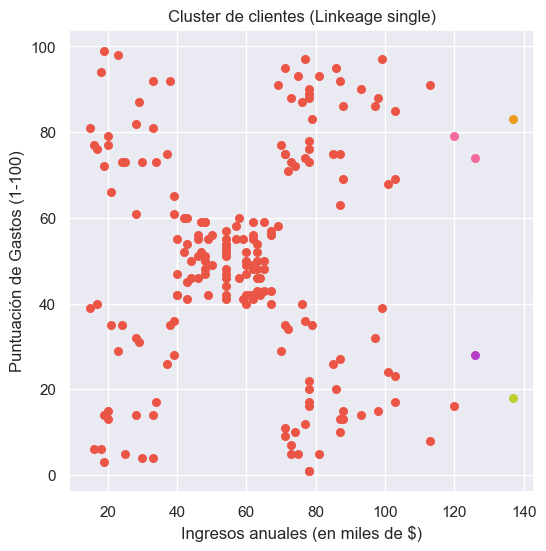

In [27]:
# Visualización de los clusters
plt.figure(figsize=(6, 6)) 
plt.scatter(X[y_single == 0, 0], X[y_single == 0, 1], s = 30, c = "#ea5545")
plt.scatter(X[y_single == 1, 0], X[y_single == 1, 1], s = 30, c = "#f46a9b")
plt.scatter(X[y_single == 2, 0], X[y_single == 2, 1], s = 30, c = "#ef9b20")
plt.scatter(X[y_single == 3, 0], X[y_single == 3, 1], s = 30, c = "#bdcf32")
plt.scatter(X[y_single == 4, 0], X[y_single == 4, 1], s = 30, c = "#b33dc6")
plt.title("Cluster de clientes (Linkeage single)", fontsize=12)
plt.xlabel("Ingresos anuales (en miles de $)", fontsize=12)
plt.ylabel("Puntuación de Gastos (1-100)", fontsize=12)
plt.show()

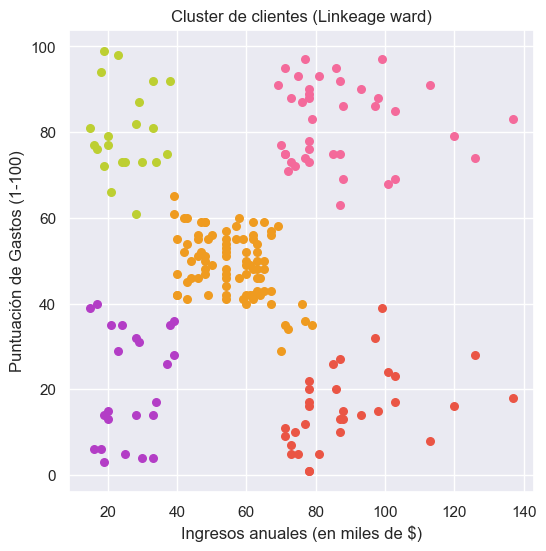

In [28]:
# Visualización de los clusters
plt.figure(figsize=(6, 6)) 
plt.scatter(X[y_ward == 0, 0], X[y_ward == 0, 1], s = 30, c = "#ea5545")
plt.scatter(X[y_ward == 1, 0], X[y_ward == 1, 1], s = 30, c = "#f46a9b")
plt.scatter(X[y_ward == 2, 0], X[y_ward == 2, 1], s = 30, c = "#ef9b20")
plt.scatter(X[y_ward == 3, 0], X[y_ward == 3, 1], s = 30, c = "#bdcf32")
plt.scatter(X[y_ward == 4, 0], X[y_ward == 4, 1], s = 30, c = "#b33dc6")
plt.title("Cluster de clientes (Linkeage ward)", fontsize=12)
plt.xlabel("Ingresos anuales (en miles de $)", fontsize=12)
plt.ylabel("Puntuación de Gastos (1-100)", fontsize=12)
plt.show()

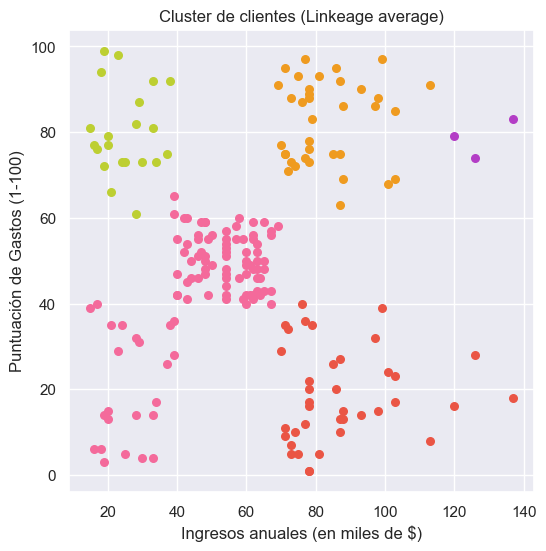

In [29]:
# Visualización de los clusters
plt.figure(figsize=(6, 6)) 
plt.scatter(X[y_average == 0, 0], X[y_average == 0, 1], s = 30, c = "#ea5545")
plt.scatter(X[y_average == 1, 0], X[y_average == 1, 1], s = 30, c = "#f46a9b")
plt.scatter(X[y_average == 2, 0], X[y_average == 2, 1], s = 30, c = "#ef9b20")
plt.scatter(X[y_average == 3, 0], X[y_average == 3, 1], s = 30, c = "#bdcf32")
plt.scatter(X[y_average == 4, 0], X[y_average == 4, 1], s = 30, c = "#b33dc6")
plt.title("Cluster de clientes (Linkeage average)", fontsize=12)
plt.xlabel("Ingresos anuales (en miles de $)", fontsize=12)
plt.ylabel("Puntuación de Gastos (1-100)", fontsize=12)
plt.show()

Por último, se deja el enlace de [SKlearn](https://scikit-learn.org/stable/modules/clustering.html) que menciona todo sus algoritmos de clustering, con casos de usos y escalabilidad